# Ch `05`: Concept `01`

## Clustering

We're going to need a Python library called the BregmanToolkit. It's available here: https://github.com/BinRoot/BregmanToolkit

One way to install it is by downloading from the GitHub link above, and then running `sudo python setup.py install` in the downloaded directory. You will also need scipy: `sudo pip2 install scipy`. Unfortunately, this BregmanToolkit library isn't supported on Python 3, so you'll have to use Python 2.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
from bregman.suite import *

Define some hyper-parameters for clustering:

In [2]:
k = 2
max_iterations = 100

Select the location for the audio files:

In [12]:
filenames = tf.train.match_filenames_once('./audio_dataset/*.wav')
# with tf.Session() as sess:
# sess.run(tf.global_variables_initializer())
# sess.run(tf.local_variables_initializer())
# print(filenames.eval())
count_num_files = tf.size(filenames)
# print(count_num_files.eval())
filename_queue = tf.train.string_input_producer(filenames)

reader = tf.WholeFileReader()
filename, file_contents = reader.read(filename_queue)

chromo = tf.placeholder(tf.float32)

max_freqs = tf.argmax(chromo, 0)

Create a helper function to get the next audio file's Chromogram:

Chromogram:
A sound may produce 12 kinds of pitches. In music terminology, the 12 pitches are C, C#,
D, D#, E, F, F#, G, G#, A, A#, and B. Listing 5.2 shows how to retrieve the contribution of
each pitch in a 0.1 second interval, resulting in a matrix with 12 rows. The number of columns
grows as the length of the audio file increases. Specifically, there will be 10*t columns for a t
second audio. This matrix is also called a chromogram of the audio.

In [4]:
def get_next_chromogram(sess):
    audio_file = sess.run(filename)
    print('Loading {}'.format(audio_file))
    F = Chromagram(audio_file, nfft=16384, wfft=8192, nhop=2205)
    return F.X, audio_file

And create a helper function to extract a feature vector from the Chromogram data:

We count the number of times each pitch shows up in the audio file as a histogram, forming a 12-dimensional vector. If we normalize the vector so thatvall the counts add up to 1, then we can easily compare audio of different lengths.

In [5]:
def extract_feature_vector(sess, chromo_data):
    num_features, num_samples = np.shape(chromo_data)
    freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
    hist, bins = np.histogram(freq_vals, bins=range(num_features + 1))
    normalized_hist = hist.astype(float) / num_samples
    return normalized_hist

Extract a dataset of feature vectors by calling our helper functions above:

In [6]:
def get_dataset(sess):
    num_files = sess.run(count_num_files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord ,sess=sess)
    xs = list()
    names = list()
    
    for _ in range(num_files):
        plt.figure()
        chromo_data, filename = get_next_chromogram(sess)

        plt.subplot(1, 2, 1)
        plt.imshow(chromo_data, cmap='Greys', interpolation='nearest')
        plt.title('Visualization of Sound Spectrum')

        plt.subplot(1, 2, 2)
        freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
        plt.hist(freq_vals)
        plt.title('Histogram of Notes')
        plt.xlabel('Musical Note')
        plt.ylabel('Count')
        plt.savefig('{}.png'.format(filename))
        plt.show()

        names.append(filename)
        x = extract_feature_vector(sess, chromo_data)
        xs.append(x)
    xs = np.asmatrix(xs)
    coord.request_stop()
    coord.join(threads)
    return xs, names

## k-means clustering 


First initialise the clusters based on the locations of the first k(2) samples

In [7]:
def initial_cluster_centroids(X, k):
    return X[0:k, :]

### We need to calculate the euclidean distances of each sample from the centroids and cluster each sample to the centroid from which it has the lowest distance

The `assign_cluster`function has some interesting operations that make clever use of broadcasting using [degenerate dimensions](https://www.tensorflow.org/performance/xla/broadcasting). 

First some details on what we want to do. We are doing clustering with two clusters. Our data are in a 12-dimensional space, since our chromograms use 12 bins (or notes) to aggregate frequencies. So our clusters are defined by 2 centroids each with 12 dimensions. So the shape of an array storing the centroids is (2,12). 

Let's focus on a single operation to understand broadcasting better, `tf.subtract`. Our data are in an array with shape (n,12). in this example we have 5 samples so our shape is (5,12). We would like to subtract each centroid from all of our samples and store the result in an array. This array can have shape (2,5,12). How are we going to accomplish this? We add dummy or degenerate dimensions to our centroid (`centroids`) and data (`X`) array as follows. 

`centroids` (2,12) -> (2,1,12) so we need to add this degenerate dimension at index [1]. We can accomplish this using `tf.expand_dims(centroids, 1)`. The `centroids` array looks close to what we want to have in our final result (2,5,12). The next step if to broadcast this `centroids` (2,1,12) array in our `X` data array. To do this we add a degenerate dimension to `X` using `tf.expand_dims(X, 0)` and the shape of `X` becomes (1,5,12). 

In general if we have an array A->(k,N) that we would like to apply an operation between each row A[i,:] to the row of another array B->(m,N) we need to first think of the final shape of the result. In this case it would be (k,m,N). So then we use `tf.expand_dims` to make A->(k,1,N) and B->(1,m,N). The final result of the operation will be (k,m,N).

In [8]:
def assign_cluster(X, centroids):
    '''
    X: tensor (5,12) where 5 is the number of samples and 12 the features from the chromogram
    see function extract_feature_vector
    centroids: tensor (2,12) holding the coordinates of the centroids
    '''    
    # see above for why we expand dimensions
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    # calculate distances of each sample(5) from the centroids
    # distances shape -> (2,5)
    distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
    # assign samples to cluster based on minimum distance
    # clusters shape->(5), example [1,0,1,0,0]
    clusters = tf.argmin(distances, 0)
    return clusters

### Recompute the centroid coordinates based on the mean coordinates of the members of the clusters

`tf.unsorted_segment_sum(A,B,C)` returns the sum of `A` according to index `B`. `C` defines the total number of groups. Note that in case there is a group in `C` not represented in `B` a zero will be returned in the sum. 
For example if the shape of `A` is (10,100) `B` -> (10) and `C` will be a scaler e.g. 3.

In [9]:

def recompute_centroids(X, Y):
    '''
    X: tensor (5,12) where 5 is the number of samples and 12 the features from the chromogram
    see function extract_feature_vector
    Y: tensor (5) holding the numeric labels of the clusters, example [0,1,0,1,1] 
    '''
    # Calculate the sum of each dimension according to the assigned cluster
    # sums is a (2,12) tensor holding the sums of each coordinate for the samples assigned to a specific cluster
    sums = tf.unsorted_segment_sum(X, Y, k)
    # to calculate the sum we also need the number of samples used to calculate the sum above
    # counts is again a (2,12) tensor
    counts = tf.unsorted_segment_sum(tf.ones_like(X), Y, k)
    # the updated centroids are located at the means of the dimensions of the samples belonging to each cluster
    meansClusters=sums / counts    
    return meansClusters

Open a session, obtain a dataset, and cluster the data:

Loading ./audio_dataset/scream_1.wav


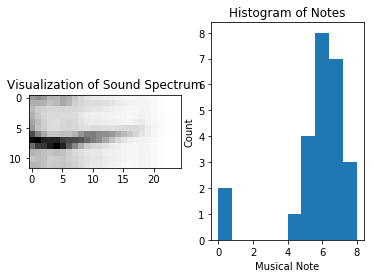

Loading ./audio_dataset/scream_2.wav


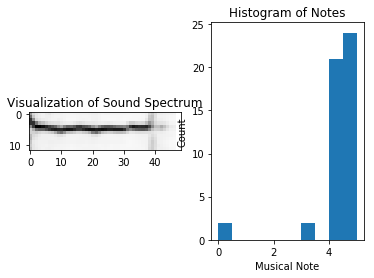

Loading ./audio_dataset/cough_1.wav


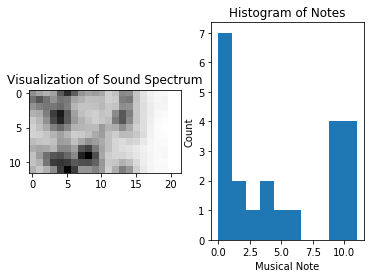

Loading ./audio_dataset/scream_3.wav


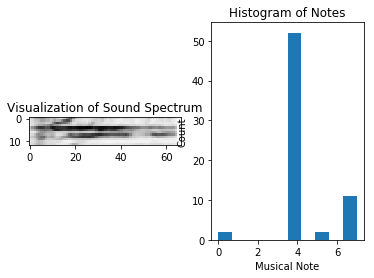

Loading ./audio_dataset/cough_2.wav


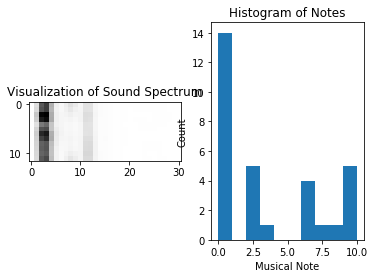

[(0, './audio_dataset/scream_1.wav'), (1, './audio_dataset/scream_2.wav'), (0, './audio_dataset/cough_1.wav'), (1, './audio_dataset/scream_3.wav'), (0, './audio_dataset/cough_2.wav')]


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    X, names = get_dataset(sess)
    centroids = initial_cluster_centroids(X, k)
    i, converged = 0, False
    while not converged and i < max_iterations:
        i += 1
        Y = assign_cluster(X, centroids)
        centroids = sess.run(recompute_centroids(X, Y))
    print(zip(sess.run(Y), names))
